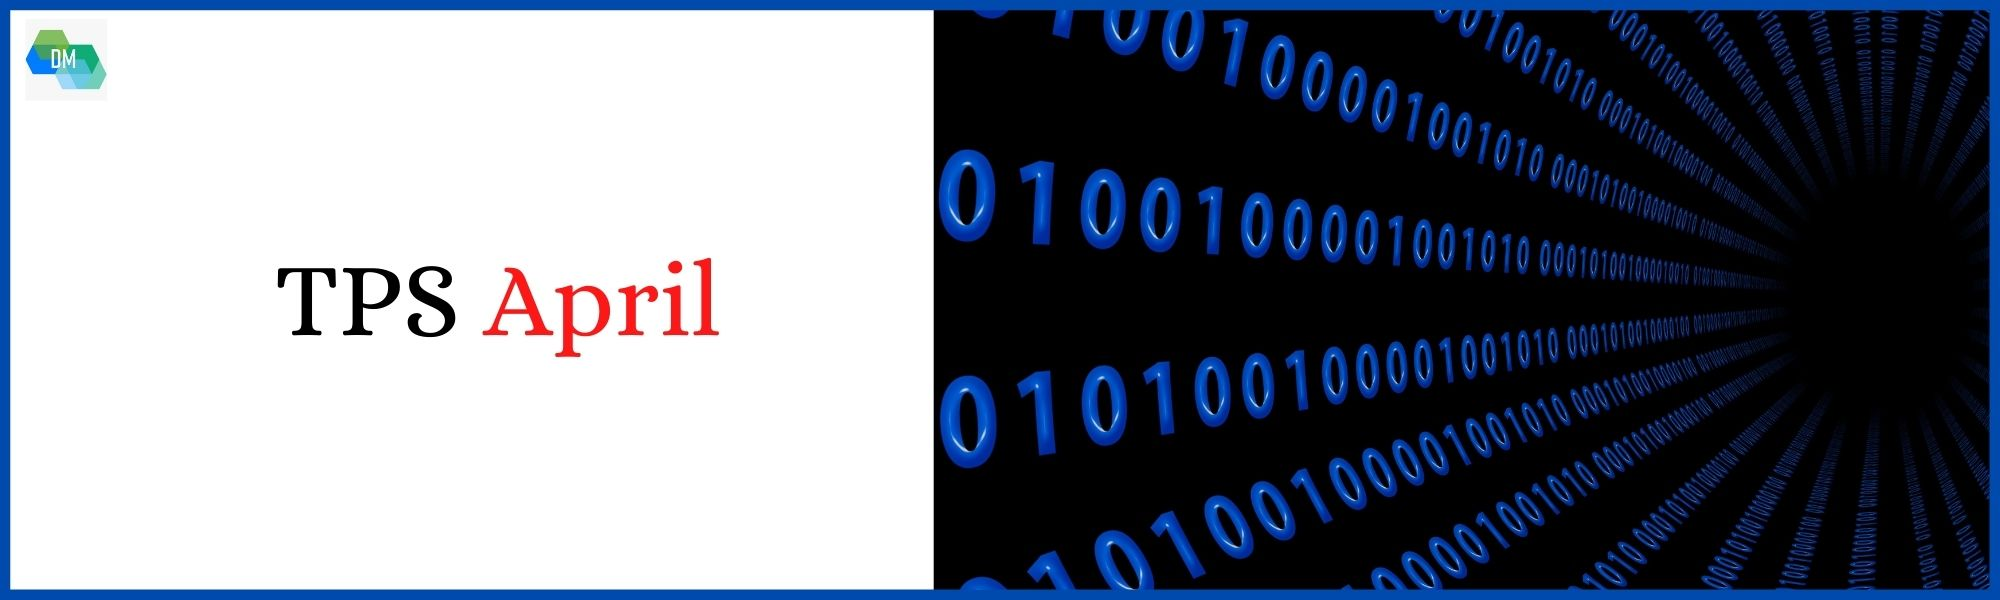

**Observations on this TPS dataset:**
- `state` column is the target variable which is associated to each sequence.

- `Train` dataset has `15,58,080` rows and `16` columns which contains`13` sensor columns, `1` subject id column, `1` time step recording column, and `1` column of `sequence id`
- `Test` dataset has `733,080` rows and `16` columns which contains`13` sensor columns, `1` subject id column, `1` time step recording column, and `1` column of `sequence id`
- `Train_labels` dataset has `25,968` rows which contains `target` column and `1` column of `sequence id`
- No missing values in train, test and train_labels dataset

**Training File Description:**

The training set, comprising `26,000` 60-second recordings of thirteen biological sensors for almost one thousand experimental participants.

- `sequence` - a unique id for each sequence
- `subject` - a unique id for the subject in the experiment
- `step` - time step of the recording, in one second intervals
- `sensor_00` - `sensor_12` - the value for each of the thirteen sensors at that time step

**Train Labels Description:**

This set comprises the class label for each sequence.

- `sequence` - the unique id for each sequence.
- `state` - the state associated to each sequence. This is the target which you are trying to predict.

**Test File**
: For each of the ~`12,000` sequences, you should predict a value for that sequence's state.

### <h3 style="background-color:#95f9e3;color:#0077b6;text-align: center;padding-top: 5px;padding-bottom: 5px;border-radius: 15px 50px;"><strong><centre>Importing Libraries & Packages 📚 </centre></strong></h3>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GroupKFold

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D

import warnings
warnings.filterwarnings('ignore')

2022-04-28 10:46:56.102239: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-04-28 10:46:56.102345: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### <h3 style="background-color:#95f9e3;color:#0077b6;text-align: center;padding-top: 5px;padding-bottom: 5px;border-radius: 15px 50px;"><strong><centre>Importing & Reading the dataset 📝 </centre></strong></h3>

In [2]:
df_train = pd.read_csv("../input/tabular-playground-series-apr-2022/train.csv")
df_test = pd.read_csv("../input/tabular-playground-series-apr-2022/test.csv")
df_subm = pd.read_csv("../input/tabular-playground-series-apr-2022/sample_submission.csv")
df_labels = pd.read_csv("../input/tabular-playground-series-apr-2022/train_labels.csv")

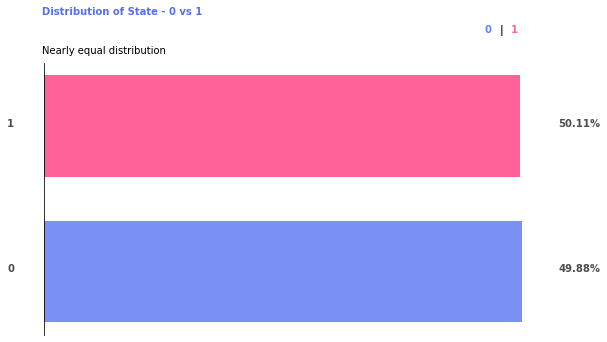

In [3]:
x = df_labels['state'].value_counts()

fig,ax=plt.subplots(figsize=(9,5))
ax.barh([1],x.values[1],height=0.7,color='#ff206e',alpha=0.7)
plt.text(-1000,1, '1', {'font': 'Trebuchet MS','weight':'bold','style':'normal', 'color':'black'},alpha = 0.7)
plt.text(14000,1, '50.11%', {'font': 'Trebuchet MS','weight':'bold','style':'normal', 'color':'black'},alpha = 0.7)

ax.barh([0],x.values[0],height=0.7,color='#4361ee',alpha=0.7)
plt.text(-1000,0,'0',{'font': 'Trebuchet MS','weight':'bold','style':'normal', 'color':'black'}, alpha = 0.7)
plt.text(14000,0, '49.88%',{'font': 'Trebuchet MS','weight':'bold','style':'normal', 'color':'black'}, alpha = 0.7)


plt.text(-50,1.77, 'Distribution of State - 0 vs 1',{'font': 'Trebuchet MS','weight':'bold','style':'normal', 'color':'#4361ee'}, alpha = 0.9)
plt.text(12000,1.65, '0 ', {'font': 'Trebuchet MS','weight':'bold','style':'normal', 'color':'#4361ee'},alpha = 0.8)
plt.text(12400,1.65, '|', {'font': 'Trebuchet MS','weight':'bold','style':'normal', 'color':'black'}, alpha = 0.9)
plt.text(12700,1.65, '1',  {'font': 'Trebuchet MS','weight':'bold','style':'normal', 'color':'#ff206e'},alpha = 0.7)
plt.text(-50,1.5, 'Nearly equal distribution')

ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

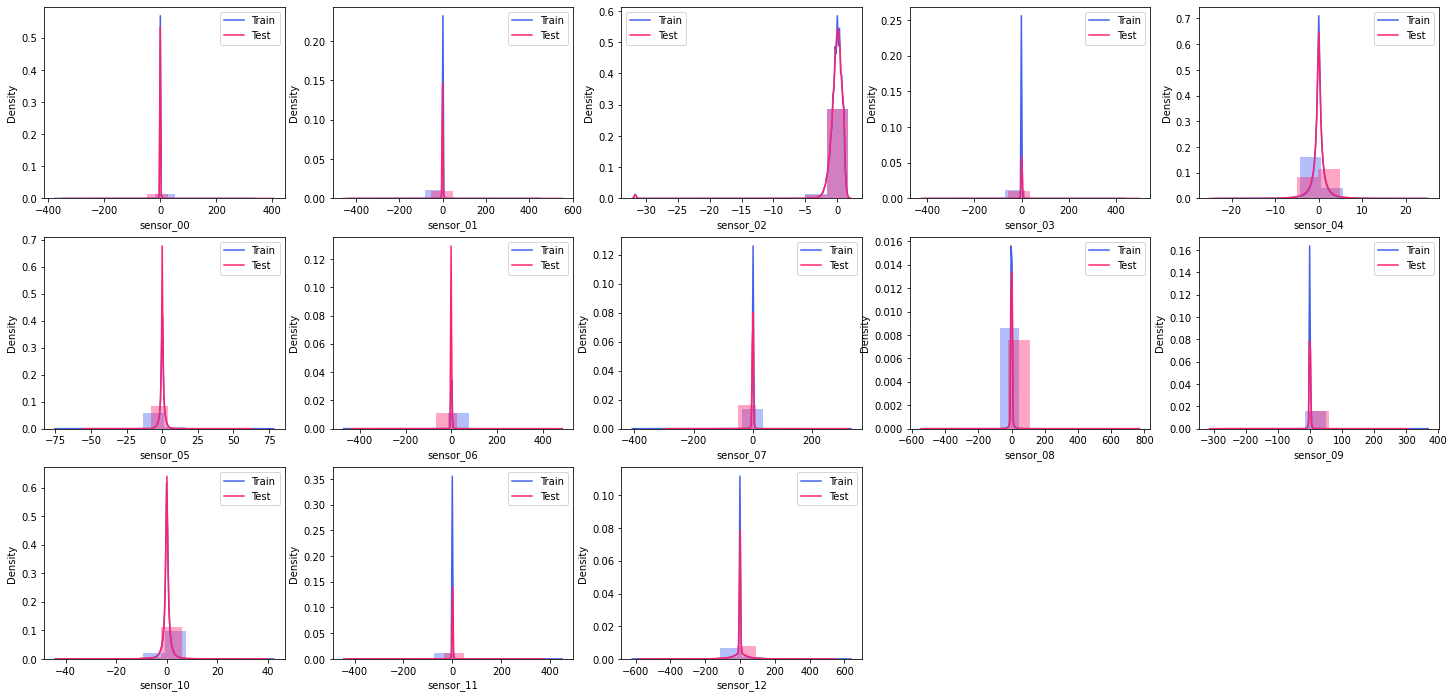

In [4]:
plt.figure(figsize=(25,12))
for i, col in enumerate(df_train.columns[3:]):
    fig = plt.subplot(3, 5, i+1)
    sns.distplot(df_train[col], bins = 10, color ='#4361ee')
    sns.distplot(df_test[col], bins = 10, color ='#ff206e')
    fig.legend(labels = ('Train','Test'))  

In [5]:
seq = df_train["sequence"]
df_train = df_train.drop(["sequence", "subject", "step"], inplace=False, axis=1).values
df_test = df_test.drop(["sequence", "subject", "step"], inplace=False, axis=1).values
df_labels = df_labels["state"]
sc = StandardScaler()
sc.fit(df_train)
df_train = sc.transform(df_train)
df_test = sc.transform(df_test)
df_train = df_train.reshape(int(len(df_train)/60), 60, 13)
df_test = df_test.reshape(int(len(df_test)/60), 60, 13)

In [6]:
# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

2022-04-28 10:49:04.768433: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-28 10:49:04.771725: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-04-28 10:49:04.771760: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-28 10:49:04.771791: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (2e507e97e59d): /proc/driver/nvidia/version does not exist
2022-04-28 10:49:04.774626: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

### <h3 style="background-color:#95f9e3;color:#0077b6;text-align: center;padding-top: 5px;padding-bottom: 5px;border-radius: 15px 50px;"><strong><centre>LSTM ⏳</centre></strong></h3>

In [7]:
with tpu_strategy.scope():
        model = keras.Sequential([
            layers.Input(shape=(60, 13)),
            layers.BatchNormalization(),
            layers.Bidirectional(layers.LSTM(1024, return_sequences=True)),
            layers.Bidirectional(layers.LSTM(512, return_sequences=True)),
            layers.Bidirectional(layers.LSTM(512, return_sequences=True)),
            layers.Bidirectional(layers.LSTM(256, return_sequences=True)),
            layers.Bidirectional(layers.LSTM(256, return_sequences=True)),
            layers.Bidirectional(layers.LSTM(128, return_sequences=True)),
            layers.Conv1D(32, 7),
            layers.MaxPooling1D(),
            layers.Conv1D(64, 3),
            layers.MaxPooling1D(),
            layers.Conv1D(128, 3),
            layers.GlobalMaxPooling1D(),
            layers.Dense(150, activation="swish"),
            layers.Dense(50, activation="swish"),
            layers.Dense(1, activation="sigmoid")], name='lstm_model')
        model.compile(optimizer="adam", loss='binary_crossentropy',metrics=[keras.metrics.AUC(name='auc')])

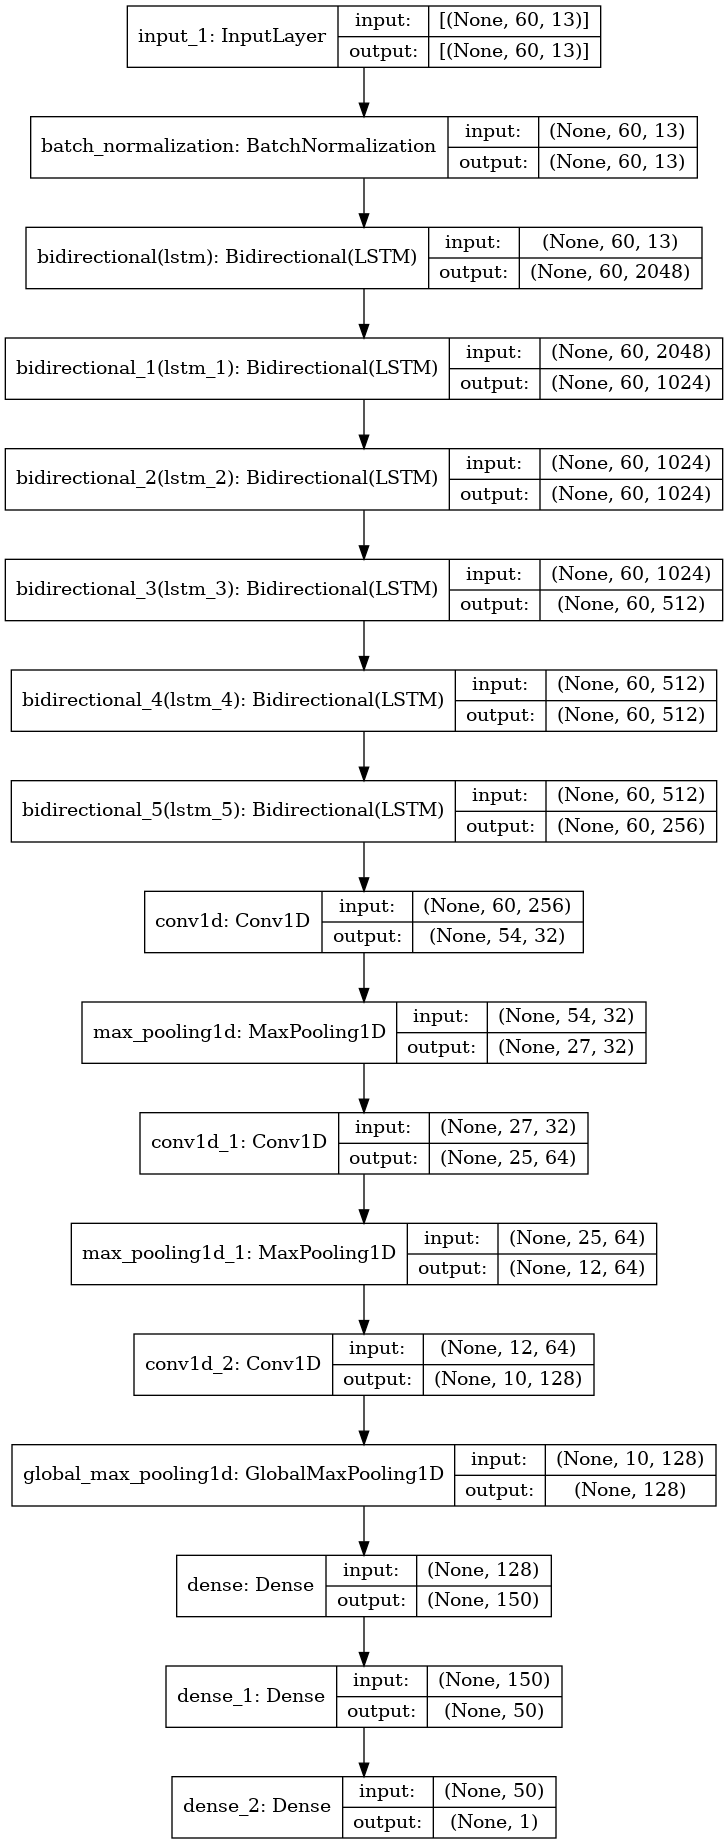

In [8]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='cnn_plot.png', show_shapes=True, show_layer_names=True)

In [9]:
cv = 0
pred = []
kfolds = GroupKFold(n_splits = 5)
for fold_idx, (train_idx, valid_idx) in enumerate(kfolds.split(df_train, df_labels, seq.unique())):
    print("*"*20, f"Fold {fold_idx+1}", "*"*20)
    X_train, X_valid = df_train[train_idx], df_train[valid_idx]
    y_train, y_valid = df_labels.iloc[train_idx].values, df_labels.iloc[valid_idx].values
    model.fit(X_train, y_train, validation_data = (X_valid, y_valid), epochs = 100, batch_size = 256, 
              callbacks = [keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True,verbose = 1)])
    cv += roc_auc_score(y_valid, model.predict(X_valid).squeeze())
    pred.append(model.predict(df_test))

******************** Fold 1 ********************
Epoch 1/100
82/82 [==============================] - 69s 412ms/step - loss: 0.6671 - auc: 0.6319 - val_loss: 0.6018 - val_auc: 0.7596
Epoch 2/100
82/82 [==============================] - 9s 115ms/step - loss: 0.5682 - auc: 0.7773 - val_loss: 0.4965 - val_auc: 0.8447
Epoch 3/100
82/82 [==============================] - 9s 116ms/step - loss: 0.4948 - auc: 0.8391 - val_loss: 0.4248 - val_auc: 0.8916
Epoch 4/100
82/82 [==============================] - 9s 115ms/step - loss: 0.4332 - auc: 0.8807 - val_loss: 0.3553 - val_auc: 0.9267
Epoch 5/100
82/82 [==============================] - 9s 116ms/step - loss: 0.3454 - auc: 0.9267 - val_loss: 0.3724 - val_auc: 0.9363
Epoch 6/100
82/82 [==============================] - 9s 115ms/step - loss: 0.3098 - auc: 0.9414 - val_loss: 0.3017 - val_auc: 0.9466
Epoch 7/100
82/82 [==============================] - 9s 115ms/step - loss: 0.2905 - auc: 0.9490 - val_loss: 0.3118 - val_auc: 0.9490
Epoch 8/100
82/82 [

In [10]:
df_subm["state"] = sum(pred)/5
df_subm.to_csv("submission_lstm.csv", index=False)
df_subm

,sequence,state
0,25968,0.994406
1,25969,0.998117
2,25970,0.000067
3,25971,0.989074
4,25972,0.365103
...,...,...
12213,38181,0.183373
12214,38182,0.632963
12215,38183,0.088957
12216,38184,0.435582


### <h3 style="background-color:#95f9e3;color:#0077b6;text-align: center;padding-top: 5px;padding-bottom: 5px;border-radius: 15px 50px;"><strong><centre>If you found this notebook useful, please Upvote. Thanks! </centre></strong></h3>